In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading the tokenized tweets**

In [3]:
tweets_train_tokenized = pd.read_csv('csvs/tweets_train_tokens.csv', index_col=False)
tweets_train_tokenized_message = pd.Series(tweets_train_tokenized.message)
# Converting Panda series into Unicode datatype as required by vectorizers
tweets = tweets_train_tokenized_message.astype('U').values
tweets

array(['arirang simply kpop kim hyung jun cross ha yeong playback',
       'read politico article donald trump running mate tom brady list likely choice',
       'type bazura project google image image photo dad glenn moustache whatthe',
       ..., 'bring dunkin iced coffee tomorrow hero',
       'currently holiday portugal come home tomorrow poland tuesday holocaust memorial trip',
       'ladykiller saturday aternoon'], dtype=object)

In [4]:
# Loading the tfidvectorizer from disk
import joblib
tfidf= joblib.load('vectors/tfidf.sav')

In [5]:
tweets = tfidf.transform(tweets).toarray()
tweets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**B. Loading our target labels**

In [6]:
tweets_train_y = pd.read_csv('csvs/tweets_train_y.csv', index_col=False)
tweets_train_y = pd.Series(tweets_train_y['0'])
tweets_train_y = tweets_train_y.values
tweets_train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [7]:
unique_elements, counts_elements = np.unique(tweets_train_y, return_counts=True)
print("Frequency of unique values of our target labels:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of our target labels:
[[    0     1     2]
 [ 7748 22256 19671]]


**C. Combining our inputs and targets**

In [8]:
data = np.column_stack([tweets,tweets_train_y])
data

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

**D. Separating the minority class from the dataset**

In [9]:
df_train_negative = data[data[:,-1] == 0]
df_train_negative

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
len(df_train_negative)

7748

In [11]:
df_train_neutral = data[data[:,-1] == 1]
df_train_neutral
len(df_train_neutral)

22256

In [12]:
df_train_positive = data[data[:,-1] == 2]
df_train_positive
len(df_train_positive)

19671

We will increase the population of our negative class so that its final population is equal to the average of the population of neutral and the positive class.

In [13]:
ave_pos_neutral = int(np.round(np.mean([len(df_train_neutral), len(df_train_positive)]),0))
ave_pos_neutral

20964

In [14]:
X_train = data[:,:-1]
X_train = torch.from_numpy(X_train).type(torch.float)

y_train = data[:,-1]
y_train = torch.from_numpy(y_train).type(torch.float)

X_train_negative = df_train_negative[:,:-1]
X_train_negative = torch.from_numpy(X_train_negative).type(torch.float)
X_train_negative.shape

torch.Size([7748, 5000])

**F. Applying Variational Autoencoder on the `Negative` class**

In [15]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=50, num_dim=5000):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=500)
        self.encoder_layer_2 = nn.Linear(in_features=500, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=500)
        self.decoder_layer_2 = nn.Linear(in_features=500, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [16]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [17]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [18]:
num_features = 50
model = VariationalAutoencoder(num_features=num_features)
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32

In [19]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [20]:
# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(X_train_negative)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [21]:
import time

epochs = 50
losses = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "./torch_models/variational-autoencoder.pth")

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

Epoch: 0


100%|██████████| 243/243 [00:29<00:00,  8.28it/s, loss=0.00547]


Ave Loss: 0.06435011452784448
Epoch: 1


100%|██████████| 243/243 [00:19<00:00, 12.34it/s, loss=0.00522]


Ave Loss: 0.006689023749649893
Epoch: 2


100%|██████████| 243/243 [00:17<00:00, 14.03it/s, loss=0.00465]


Ave Loss: 0.0050555123725269805
Epoch: 3


100%|██████████| 243/243 [00:18<00:00, 12.90it/s, loss=0.00483]


Ave Loss: 0.004679146918387693
Epoch: 4


100%|██████████| 243/243 [00:20<00:00, 12.02it/s, loss=0.00458]


Ave Loss: 0.004565788800885648
Epoch: 5


100%|██████████| 243/243 [00:20<00:00, 11.75it/s, loss=0.00466]


Ave Loss: 0.004522164020718002
Epoch: 6


100%|██████████| 243/243 [00:20<00:00, 11.83it/s, loss=0.00463]


Ave Loss: 0.004501440506735089
Epoch: 7


100%|██████████| 243/243 [00:20<00:00, 11.65it/s, loss=0.00474]


Ave Loss: 0.004492653631547719
Epoch: 8


100%|██████████| 243/243 [00:31<00:00,  7.77it/s, loss=0.00473]


Ave Loss: 0.004487104577859366
Epoch: 9


100%|██████████| 243/243 [00:20<00:00, 11.92it/s, loss=0.00481]


Ave Loss: 0.0044842906920967525
Epoch: 10


100%|██████████| 243/243 [00:20<00:00, 11.93it/s, loss=0.00493]


Ave Loss: 0.004481997959883002
Epoch: 11


100%|██████████| 243/243 [00:20<00:00, 12.03it/s, loss=0.00442]


Ave Loss: 0.0044809407727034005
Epoch: 12


100%|██████████| 243/243 [00:19<00:00, 12.30it/s, loss=0.00457]


Ave Loss: 0.004483553094199165
Epoch: 13


100%|██████████| 243/243 [00:18<00:00, 12.97it/s, loss=0.00466]


Ave Loss: 0.004502067384559186
Epoch: 14


100%|██████████| 243/243 [00:26<00:00,  9.20it/s, loss=0.0049] 


Ave Loss: 0.004523306092393006
Epoch: 15


100%|██████████| 243/243 [00:25<00:00,  9.41it/s, loss=0.00488]


Ave Loss: 0.0045191050553119476
Epoch: 16


100%|██████████| 243/243 [00:26<00:00,  9.13it/s, loss=0.00481]


Ave Loss: 0.004490753298495041
Epoch: 17


100%|██████████| 243/243 [00:21<00:00, 11.42it/s, loss=0.00486]


Ave Loss: 0.004480150516754315
Epoch: 18


100%|██████████| 243/243 [00:19<00:00, 12.53it/s, loss=0.0045] 


Ave Loss: 0.004473221869641003
Epoch: 19


100%|██████████| 243/243 [00:19<00:00, 12.53it/s, loss=0.00457]


Ave Loss: 0.004466586924491473
Epoch: 20


100%|██████████| 243/243 [00:19<00:00, 12.57it/s, loss=0.00457]


Ave Loss: 0.004469914566878797
Epoch: 21


100%|██████████| 243/243 [00:19<00:00, 12.53it/s, loss=0.00487]


Ave Loss: 0.004461004573146625
Epoch: 22


100%|██████████| 243/243 [00:19<00:00, 12.53it/s, loss=0.00452]


Ave Loss: 0.004455684408269546
Epoch: 23


100%|██████████| 243/243 [00:19<00:00, 12.52it/s, loss=0.0044] 


Ave Loss: 0.004448835076879204
Epoch: 24


100%|██████████| 243/243 [00:19<00:00, 12.45it/s, loss=0.00466]


Ave Loss: 0.0044380268484446005
Epoch: 25


100%|██████████| 243/243 [00:19<00:00, 12.16it/s, loss=0.00494]


Ave Loss: 0.00442909935121367
Epoch: 26


100%|██████████| 243/243 [00:20<00:00, 12.02it/s, loss=0.00483]


Ave Loss: 0.004420411874589974
Epoch: 27


100%|██████████| 243/243 [00:20<00:00, 11.86it/s, loss=0.00452]


Ave Loss: 0.00441379712342664
Epoch: 28


100%|██████████| 243/243 [00:20<00:00, 11.90it/s, loss=0.00468]


Ave Loss: 0.004401441372225805
Epoch: 29


100%|██████████| 243/243 [00:21<00:00, 11.42it/s, loss=0.00451]


Ave Loss: 0.0043981554113144495
Epoch: 30


100%|██████████| 243/243 [00:21<00:00, 11.50it/s, loss=0.00459]


Ave Loss: 0.004371441689936958
Epoch: 31


100%|██████████| 243/243 [00:21<00:00, 11.54it/s, loss=0.00464]


Ave Loss: 0.004365278162644723
Epoch: 32


100%|██████████| 243/243 [00:21<00:00, 11.29it/s, loss=0.00458]


Ave Loss: 0.004359198653679571
Epoch: 33


100%|██████████| 243/243 [00:21<00:00, 11.55it/s, loss=0.00464]


Ave Loss: 0.0043555606949936465
Epoch: 34


100%|██████████| 243/243 [00:21<00:00, 11.54it/s, loss=0.00441]


Ave Loss: 0.004349054310685445
Epoch: 35


100%|██████████| 243/243 [00:20<00:00, 11.61it/s, loss=0.00464]


Ave Loss: 0.00434815584693426
Epoch: 36


100%|██████████| 243/243 [00:21<00:00, 11.53it/s, loss=0.00455]


Ave Loss: 0.0043452434364415
Epoch: 37


100%|██████████| 243/243 [00:20<00:00, 11.59it/s, loss=0.00456]


Ave Loss: 0.004345553940537658
Epoch: 38


100%|██████████| 243/243 [00:20<00:00, 11.66it/s, loss=0.00462]


Ave Loss: 0.00434505621377578
Epoch: 39


100%|██████████| 243/243 [00:21<00:00, 11.42it/s, loss=0.00468]


Ave Loss: 0.004344417619683737
Epoch: 40


100%|██████████| 243/243 [00:20<00:00, 12.03it/s, loss=0.00454]


Ave Loss: 0.004344401436516777
Epoch: 41


100%|██████████| 243/243 [00:20<00:00, 12.08it/s, loss=0.00466]


Ave Loss: 0.004343313808886357
Epoch: 42


100%|██████████| 243/243 [00:20<00:00, 11.96it/s, loss=0.00457]


Ave Loss: 0.004342238284616804
Epoch: 43


100%|██████████| 243/243 [00:20<00:00, 11.97it/s, loss=0.00458]


Ave Loss: 0.004342209152999974
Epoch: 44


100%|██████████| 243/243 [00:19<00:00, 12.27it/s, loss=0.00458]


Ave Loss: 0.004341509609019438
Epoch: 45


100%|██████████| 243/243 [00:21<00:00, 11.23it/s, loss=0.00454]


Ave Loss: 0.00434081570279819
Epoch: 46


100%|██████████| 243/243 [00:20<00:00, 12.00it/s, loss=0.00454]


Ave Loss: 0.0043404525607717015
Epoch: 47


100%|██████████| 243/243 [00:19<00:00, 12.30it/s, loss=0.00453]


Ave Loss: 0.004340189167992078
Epoch: 48


100%|██████████| 243/243 [00:20<00:00, 11.76it/s, loss=0.00449]


Ave Loss: 0.004339559042036778
Epoch: 49


100%|██████████| 243/243 [00:20<00:00, 12.04it/s, loss=0.00445]


Ave Loss: 0.0043393310059797125
Training duration: 1052.2405738830566 seconds


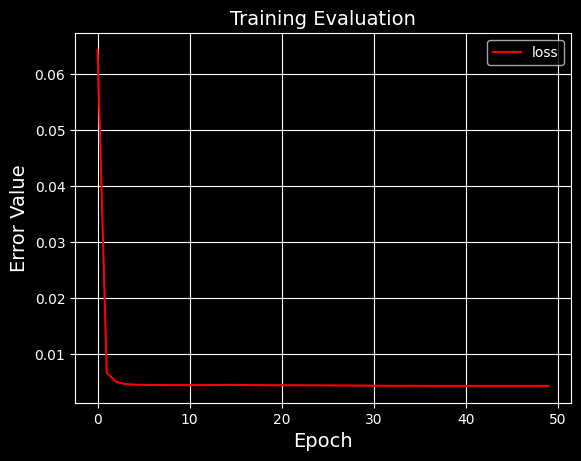

In [22]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [23]:
import random

# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
sampled_logvar = torch.Tensor([np.zeros(num_features)])

X_train_negative_copy = X_train_negative.detach().cpu().numpy().copy()
added_data_to_minority = []

for i in range(ave_pos_neutral-len(X_train_negative)):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    reconstruction = reconstruction[0].detach().cpu().numpy()
    added_data_to_minority.append(reconstruction)

added_data_to_minority

C:\Users\acer\AppData\Local\Temp\ipykernel_39896\1927566234.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


[array([3.0112053e-05, 4.0999171e-04, 1.8005099e-04, ..., 5.7512429e-04,
        2.0185192e-04, 2.5829437e-04], dtype=float32),
 array([5.0689119e-05, 6.8395492e-04, 2.6685518e-04, ..., 8.3954830e-04,
        3.2414834e-04, 3.1505493e-04], dtype=float32),
 array([4.0401283e-05, 5.9133570e-04, 1.5654798e-04, ..., 8.5072295e-04,
        2.4050182e-04, 2.7548836e-04], dtype=float32),
 array([6.0999955e-05, 7.0945127e-04, 2.2877502e-04, ..., 9.1956771e-04,
        4.6109749e-04, 4.8109770e-04], dtype=float32),
 array([5.9478090e-05, 4.7811834e-04, 1.8672628e-04, ..., 1.2091064e-03,
        2.1276802e-04, 3.4006653e-04], dtype=float32),
 array([6.1626088e-05, 5.2256737e-04, 1.5780584e-04, ..., 8.8821445e-04,
        2.1848295e-04, 3.4007043e-04], dtype=float32),
 array([6.6177417e-05, 5.4903683e-04, 1.2581445e-04, ..., 1.1880000e-03,
        4.1925983e-04, 3.7615903e-04], dtype=float32),
 array([4.9372662e-05, 6.4295571e-04, 2.5171373e-04, ..., 8.6774898e-04,
        3.7490227e-04, 3.877839

In [24]:
X_negative = np.concatenate((X_train_negative_copy, added_data_to_minority))
X_negative.shape

(20964, 5000)

In [25]:
X_negative = pd.DataFrame(X_negative)
X_negative[5000] = 0
X_negative

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20959,0.000051,0.000604,0.000176,0.000144,0.000515,0.000606,0.000057,0.000124,0.001340,0.000488,...,0.000254,2.857842e-06,0.001973,0.000438,0.000720,0.000238,0.000749,0.000323,0.000343,0
20960,0.000092,0.000755,0.000272,0.000249,0.000827,0.000730,0.000149,0.000176,0.002006,0.000840,...,0.000633,5.525983e-06,0.003514,0.000621,0.000844,0.000254,0.001343,0.000359,0.000502,0
20961,0.000037,0.000370,0.000114,0.000114,0.000368,0.000553,0.000070,0.000090,0.000868,0.000445,...,0.000291,2.306719e-06,0.001581,0.000405,0.000404,0.000139,0.001075,0.000181,0.000289,0
20962,0.000044,0.000491,0.000127,0.000170,0.000632,0.000454,0.000067,0.000092,0.001417,0.000674,...,0.000361,3.287385e-06,0.002735,0.000546,0.000745,0.000214,0.000767,0.000283,0.000281,0


In [26]:
df_train_neutral = pd.DataFrame(df_train_neutral)
df_train_neutral

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
df_train_positive = pd.DataFrame(df_train_positive)
df_train_positive

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.623108,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
19667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.481976,2.0
19668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
19669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.0


In [28]:
df_balanced = pd.concat([X_negative, df_train_neutral, df_train_positive], ignore_index=True)
df_balanced = df_balanced.sample(frac = 1)
df_balanced

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
10356,0.000046,0.000308,0.000130,0.000109,0.000401,0.000584,0.000063,0.000086,0.001058,0.000408,...,0.000309,0.000002,0.001849,0.000349,0.000445,0.000181,0.000675,0.000179,0.000295,0.0
37179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
11935,0.000052,0.000506,0.000148,0.000166,0.000448,0.000619,0.000078,0.000113,0.001241,0.000561,...,0.000323,0.000004,0.002170,0.000514,0.000500,0.000233,0.000981,0.000229,0.000313,0.0
25472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
49791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
30343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
34099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
6812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [29]:
df_balanced.iloc[:,-1].value_counts(normalize=True)

1.0    0.353882
0.0    0.333339
2.0    0.312779
Name: 5000, dtype: float64

In [30]:
df_inputs = df_balanced.iloc[:,:-1].values
df_inputs = torch.from_numpy(df_inputs).type(torch.float)
df_inputs

tensor([[4.5576e-05, 3.0794e-04, 1.3047e-04,  ..., 6.7453e-04, 1.7936e-04,
         2.9505e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2047e-05, 5.0618e-04, 1.4842e-04,  ..., 9.8053e-04, 2.2889e-04,
         3.1280e-04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.2441e-05, 2.8238e-04, 8.2643e-05,  ..., 6.1632e-04, 1.5307e-04,
         1.9238e-04]])

In [31]:
df_targets = df_balanced.iloc[:,-1].values
df_targets = torch.from_numpy(df_targets).type(torch.LongTensor)
df_targets

tensor([0, 1, 0,  ..., 1, 0, 0])

In [32]:
df_targets.dtype

torch.int64

In [33]:
df_inputs.dtype

torch.float32

In [34]:
df_inputs.shape

torch.Size([62891, 5000])

In [35]:
df_targets.shape

torch.Size([62891])

In [49]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class BalancedNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
        #self.dropout = nn.Dropout(p=0.75)
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y

In [50]:
# Create an instance of the model and send it to target device
model_2 = BalancedNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_2

BalancedNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

In [51]:
learning_rate_2 = 0.002
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate_2)
batch_size = 128

In [52]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [53]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset_2 = MyCustomDataset(x=df_inputs, y=df_targets)

train_loader = DataLoader(
    custom_dataset_2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses_2 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_2,
        optimizer_2,
        loss_fn_2,
        batch_size
    )
    
    losses_2.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_2.state_dict() }
torch.save(state, "./torch_models/model_2.pth")

Epoch: 0


100%|██████████| 492/492 [00:07<00:00, 65.31it/s, loss=0.592]


Ave Loss: 0.7710301638618717
Epoch: 1


100%|██████████| 492/492 [00:07<00:00, 69.00it/s, loss=0.453]


Ave Loss: 0.5895291960578624
Epoch: 2


100%|██████████| 492/492 [00:07<00:00, 66.91it/s, loss=0.378]


Ave Loss: 0.5420903843350526
Epoch: 3


100%|██████████| 492/492 [00:07<00:00, 68.48it/s, loss=0.328]


Ave Loss: 0.5111896676140103
Epoch: 4


100%|██████████| 492/492 [00:07<00:00, 68.88it/s, loss=0.288]


Ave Loss: 0.48464767229023986
Epoch: 5


100%|██████████| 492/492 [00:07<00:00, 69.65it/s, loss=0.252]


Ave Loss: 0.4581931150419925
Epoch: 6


100%|██████████| 492/492 [00:07<00:00, 67.33it/s, loss=0.221]


Ave Loss: 0.4292663456947823
Epoch: 7


100%|██████████| 492/492 [00:07<00:00, 69.24it/s, loss=0.188]


Ave Loss: 0.39780412968702433
Epoch: 8


100%|██████████| 492/492 [00:07<00:00, 68.46it/s, loss=0.156]


Ave Loss: 0.36436478984428616
Epoch: 9


100%|██████████| 492/492 [00:07<00:00, 68.36it/s, loss=0.129]


Ave Loss: 0.3298769361241077
Epoch: 10


100%|██████████| 492/492 [00:07<00:00, 69.60it/s, loss=0.107]


Ave Loss: 0.2951745484932894
Epoch: 11


100%|██████████| 492/492 [00:07<00:00, 68.60it/s, loss=0.0857]


Ave Loss: 0.26109385964407666
Epoch: 12


100%|██████████| 492/492 [00:07<00:00, 68.37it/s, loss=0.0683]


Ave Loss: 0.22877520328857065
Epoch: 13


100%|██████████| 492/492 [00:07<00:00, 68.60it/s, loss=0.0551]


Ave Loss: 0.1982849832715058
Epoch: 14


100%|██████████| 492/492 [00:07<00:00, 69.13it/s, loss=0.0446]


Ave Loss: 0.17089612108874855
Epoch: 15


100%|██████████| 492/492 [00:07<00:00, 66.92it/s, loss=0.0371]


Ave Loss: 0.14664210304920752
Epoch: 16


100%|██████████| 492/492 [00:07<00:00, 68.69it/s, loss=0.0301]


Ave Loss: 0.12552783054837247
Epoch: 17


100%|██████████| 492/492 [00:07<00:00, 68.76it/s, loss=0.0256]


Ave Loss: 0.10764347703945709
Epoch: 18


100%|██████████| 492/492 [00:07<00:00, 67.29it/s, loss=0.0235]


Ave Loss: 0.09249906861639726
Epoch: 19


100%|██████████| 492/492 [00:07<00:00, 68.76it/s, loss=0.0206]


Ave Loss: 0.07994681712603424
Epoch: 20


100%|██████████| 492/492 [00:07<00:00, 68.15it/s, loss=0.0184]


Ave Loss: 0.06960073403060073
Epoch: 21


100%|██████████| 492/492 [00:07<00:00, 67.76it/s, loss=0.0159]


Ave Loss: 0.06131932042099959
Epoch: 22


100%|██████████| 492/492 [00:07<00:00, 68.21it/s, loss=0.0138]


Ave Loss: 0.05458792920103221
Epoch: 23


100%|██████████| 492/492 [00:07<00:00, 68.88it/s, loss=0.0136]


Ave Loss: 0.049225553111135356
Epoch: 24


100%|██████████| 492/492 [00:07<00:00, 66.94it/s, loss=0.0131]


Ave Loss: 0.04498041700003896
Epoch: 25


100%|██████████| 492/492 [00:07<00:00, 66.09it/s, loss=0.0105] 


Ave Loss: 0.04140007926332878
Epoch: 26


100%|██████████| 492/492 [00:07<00:00, 67.78it/s, loss=0.0129] 


Ave Loss: 0.03857052239316811
Epoch: 27


100%|██████████| 492/492 [00:07<00:00, 67.90it/s, loss=0.0085] 


Ave Loss: 0.036088205107328734
Epoch: 28


100%|██████████| 492/492 [00:07<00:00, 68.63it/s, loss=0.0106] 


Ave Loss: 0.03396599923593666
Epoch: 29


100%|██████████| 492/492 [00:07<00:00, 67.10it/s, loss=0.00928]


Ave Loss: 0.032174610994695645
Epoch: 30


100%|██████████| 492/492 [00:07<00:00, 68.48it/s, loss=0.00896]


Ave Loss: 0.03062482847362696
Epoch: 31


100%|██████████| 492/492 [00:07<00:00, 69.02it/s, loss=0.0106] 


Ave Loss: 0.029451228997185525
Epoch: 32


100%|██████████| 492/492 [00:07<00:00, 66.81it/s, loss=0.0115] 


Ave Loss: 0.028483247054112332
Epoch: 33


100%|██████████| 492/492 [00:07<00:00, 67.18it/s, loss=0.00716]


Ave Loss: 0.027617444046224068
Epoch: 34


100%|██████████| 492/492 [00:07<00:00, 68.05it/s, loss=0.0106] 


Ave Loss: 0.02672414784177729
Epoch: 35


100%|██████████| 492/492 [00:07<00:00, 68.33it/s, loss=0.00832]


Ave Loss: 0.025856432477977673
Epoch: 36


100%|██████████| 492/492 [00:07<00:00, 64.45it/s, loss=0.014]  


Ave Loss: 0.02531310935160221
Epoch: 37


100%|██████████| 492/492 [00:07<00:00, 66.51it/s, loss=0.00609]


Ave Loss: 0.024531621632177564
Epoch: 38


100%|██████████| 492/492 [00:07<00:00, 67.86it/s, loss=0.015]  


Ave Loss: 0.023668681898881203
Epoch: 39


100%|██████████| 492/492 [00:07<00:00, 68.65it/s, loss=0.00517]


Ave Loss: 0.023089811725237188
Epoch: 40


100%|██████████| 492/492 [00:07<00:00, 67.71it/s, loss=0.0206] 


Ave Loss: 0.02245669681470031
Epoch: 41


100%|██████████| 492/492 [00:06<00:00, 72.55it/s, loss=0.00242]


Ave Loss: 0.02221060429517051
Epoch: 42


100%|██████████| 492/492 [00:06<00:00, 78.27it/s, loss=0.023]  


Ave Loss: 0.02172325225759911
Epoch: 43


100%|██████████| 492/492 [00:06<00:00, 78.04it/s, loss=0.00156]


Ave Loss: 0.021432219022303835
Epoch: 44


100%|██████████| 492/492 [00:06<00:00, 79.51it/s, loss=0.0232] 


Ave Loss: 0.02110307174356185
Epoch: 45


100%|██████████| 492/492 [00:06<00:00, 79.08it/s, loss=0.00163]


Ave Loss: 0.02079114356912044
Epoch: 46


100%|██████████| 492/492 [00:06<00:00, 78.42it/s, loss=0.025]   


Ave Loss: 0.02083507794304751
Epoch: 47


100%|██████████| 492/492 [00:06<00:00, 79.19it/s, loss=0.00113] 


Ave Loss: 0.020335215578997146
Epoch: 48


100%|██████████| 492/492 [00:06<00:00, 78.55it/s, loss=0.0237]  


Ave Loss: 0.020013127349623728
Epoch: 49


100%|██████████| 492/492 [00:06<00:00, 79.07it/s, loss=0.00146] 


Ave Loss: 0.019837965042854667
Epoch: 50


100%|██████████| 492/492 [00:08<00:00, 58.75it/s, loss=0.0229]  


Ave Loss: 0.019608596056473547
Epoch: 51


100%|██████████| 492/492 [00:07<00:00, 64.18it/s, loss=0.00141] 


Ave Loss: 0.019131505111922374
Epoch: 52


100%|██████████| 492/492 [00:07<00:00, 65.67it/s, loss=0.0247]  


Ave Loss: 0.018917169367371135
Epoch: 53


100%|██████████| 492/492 [00:07<00:00, 70.08it/s, loss=0.00138] 


Ave Loss: 0.01903871200754917
Epoch: 54


100%|██████████| 492/492 [00:07<00:00, 69.51it/s, loss=0.0211]  


Ave Loss: 0.018926045083278994
Epoch: 55


100%|██████████| 492/492 [00:07<00:00, 65.79it/s, loss=0.00143] 


Ave Loss: 0.018701252737295497
Epoch: 56


100%|██████████| 492/492 [00:07<00:00, 64.07it/s, loss=0.0231]  


Ave Loss: 0.018424062083292624
Epoch: 57


100%|██████████| 492/492 [00:07<00:00, 68.89it/s, loss=0.0013]  


Ave Loss: 0.018114071909141372
Epoch: 58


100%|██████████| 492/492 [00:07<00:00, 69.27it/s, loss=0.0217]  


Ave Loss: 0.017753633804552114
Epoch: 59


100%|██████████| 492/492 [00:07<00:00, 68.18it/s, loss=0.00163] 


Ave Loss: 0.017706554408002517
Epoch: 60


100%|██████████| 492/492 [00:07<00:00, 68.72it/s, loss=0.0212]  


Ave Loss: 0.017646646357096004
Epoch: 61


100%|██████████| 492/492 [00:07<00:00, 68.97it/s, loss=0.00152] 


Ave Loss: 0.017243444648423662
Epoch: 62


100%|██████████| 492/492 [00:07<00:00, 68.07it/s, loss=0.0217]  


Ave Loss: 0.01710526574068472
Epoch: 63


100%|██████████| 492/492 [00:07<00:00, 68.78it/s, loss=0.00172] 


Ave Loss: 0.01710686191506646
Epoch: 64


100%|██████████| 492/492 [00:07<00:00, 69.50it/s, loss=0.0196]  


Ave Loss: 0.016987939310845506
Epoch: 65


100%|██████████| 492/492 [00:07<00:00, 69.37it/s, loss=0.0019]  


Ave Loss: 0.016796241873982685
Epoch: 66


100%|██████████| 492/492 [00:07<00:00, 69.27it/s, loss=0.0222]  


Ave Loss: 0.01640562525680866
Epoch: 67


100%|██████████| 492/492 [00:07<00:00, 67.91it/s, loss=0.00165] 


Ave Loss: 0.016356934206129613
Epoch: 68


100%|██████████| 492/492 [00:06<00:00, 70.61it/s, loss=0.0191]  


Ave Loss: 0.016168609641518866
Epoch: 69


100%|██████████| 492/492 [00:07<00:00, 69.28it/s, loss=0.00199] 


Ave Loss: 0.01609275680776199
Epoch: 70


100%|██████████| 492/492 [00:07<00:00, 69.84it/s, loss=0.0192]  


Ave Loss: 0.01582839590228992
Epoch: 71


100%|██████████| 492/492 [00:07<00:00, 69.72it/s, loss=0.00227] 


Ave Loss: 0.01571948566159084
Epoch: 72


100%|██████████| 492/492 [00:06<00:00, 70.29it/s, loss=0.0194]  


Ave Loss: 0.01554758672905817
Epoch: 73


100%|██████████| 492/492 [00:07<00:00, 69.11it/s, loss=0.00198] 


Ave Loss: 0.015551400501094097
Epoch: 74


100%|██████████| 492/492 [00:07<00:00, 69.75it/s, loss=0.0188]  


Ave Loss: 0.015288098019179111
Epoch: 75


100%|██████████| 492/492 [00:07<00:00, 69.05it/s, loss=0.00239] 


Ave Loss: 0.015111539013434401
Epoch: 76


100%|██████████| 492/492 [00:07<00:00, 68.54it/s, loss=0.0183]  


Ave Loss: 0.01496335377601284
Epoch: 77


100%|██████████| 492/492 [00:07<00:00, 70.17it/s, loss=0.00234] 


Ave Loss: 0.014915308603927932
Epoch: 78


100%|██████████| 492/492 [00:07<00:00, 68.76it/s, loss=0.02]    


Ave Loss: 0.014823018212325217
Epoch: 79


100%|██████████| 492/492 [00:07<00:00, 68.93it/s, loss=0.00199] 


Ave Loss: 0.014730439338763529
Epoch: 80


100%|██████████| 492/492 [00:07<00:00, 69.37it/s, loss=0.021]   


Ave Loss: 0.014457548055864067
Epoch: 81


100%|██████████| 492/492 [00:07<00:00, 69.55it/s, loss=0.00177] 


Ave Loss: 0.01445961723599121
Epoch: 82


100%|██████████| 492/492 [00:07<00:00, 69.78it/s, loss=0.0158]  


Ave Loss: 0.014262455801573691
Epoch: 83


100%|██████████| 492/492 [00:07<00:00, 68.31it/s, loss=0.00378] 


Ave Loss: 0.014224998587658449
Epoch: 84


100%|██████████| 492/492 [00:07<00:00, 69.65it/s, loss=0.0158]  


Ave Loss: 0.014062766631867838
Epoch: 85


100%|██████████| 492/492 [00:07<00:00, 69.56it/s, loss=0.00338] 


Ave Loss: 0.013819061694522407
Epoch: 86


100%|██████████| 492/492 [00:07<00:00, 69.81it/s, loss=0.0315]  


Ave Loss: 0.01381444036016502
Epoch: 87


100%|██████████| 492/492 [00:07<00:00, 70.22it/s, loss=0.00107] 


Ave Loss: 0.01375305406478086
Epoch: 88


100%|██████████| 492/492 [00:07<00:00, 69.05it/s, loss=0.0143]  


Ave Loss: 0.013582534813320944
Epoch: 89


100%|██████████| 492/492 [00:07<00:00, 70.04it/s, loss=0.00413] 


Ave Loss: 0.013317131832747424
Epoch: 90


100%|██████████| 492/492 [00:07<00:00, 68.89it/s, loss=0.0172]  


Ave Loss: 0.013155551582735271
Epoch: 91


100%|██████████| 492/492 [00:07<00:00, 69.99it/s, loss=0.00282] 


Ave Loss: 0.013075039302593057
Epoch: 92


100%|██████████| 492/492 [00:07<00:00, 67.94it/s, loss=0.0182]  


Ave Loss: 0.013054744843378183
Epoch: 93


100%|██████████| 492/492 [00:07<00:00, 68.19it/s, loss=0.0024]  


Ave Loss: 0.01288378738169511
Epoch: 94


100%|██████████| 492/492 [00:07<00:00, 69.89it/s, loss=0.017]   


Ave Loss: 0.01282833661986761
Epoch: 95


100%|██████████| 492/492 [00:07<00:00, 69.44it/s, loss=0.00307] 


Ave Loss: 0.012697157919763235
Epoch: 96


100%|██████████| 492/492 [00:07<00:00, 69.59it/s, loss=0.0166]  


Ave Loss: 0.012591905565837747
Epoch: 97


100%|██████████| 492/492 [00:07<00:00, 67.23it/s, loss=0.00314] 


Ave Loss: 0.012465608713179931
Epoch: 98


100%|██████████| 492/492 [00:07<00:00, 69.24it/s, loss=0.016]   


Ave Loss: 0.012373735598426661
Epoch: 99


100%|██████████| 492/492 [00:07<00:00, 68.26it/s, loss=0.0034]  


Ave Loss: 0.012285155744585956
Training duration: 712.5482130050659 seconds


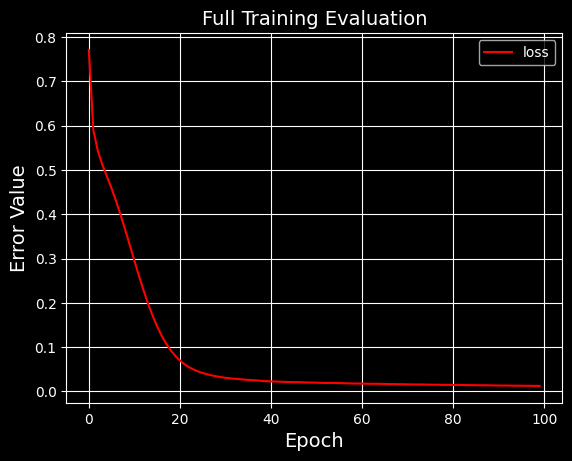

In [54]:
plt.plot(losses_2, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [55]:
model_2 = BalancedNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_2.pth")
model_2.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [56]:
X_test_vec = torch.load('tensors/X_test_vec.pt')
X_test_vec

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [57]:
y_test = torch.load('tensors/y_test.pt')
y_test

tensor([1, 2, 2,  ..., 1, 2, 1])

In [58]:
predictions_2 = model_2.forward(X_test_vec)
predictions_2 = torch.softmax(predictions_2, dim=1)
predictions_2 = torch.argmax(predictions_2, dim=1)
predictions_2

tensor([1, 0, 1,  ..., 0, 2, 1])

In [59]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions_2)
accuracy

0.44167086059386007

In [60]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, predictions_2, average='macro')
recall

0.3697894034886371

In [61]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_2))

              precision    recall  f1-score   support

           0       0.20      0.13      0.16      1550
           1       0.47      0.64      0.54      4451
           2       0.47      0.34      0.39      3934

    accuracy                           0.44      9935
   macro avg       0.38      0.37      0.36      9935
weighted avg       0.43      0.44      0.42      9935



In [62]:
torch.save(df_inputs, 'tensors/df_inputs.pt')

In [63]:
torch.save(df_targets, 'tensors/df_targets.pt')